# Variable encoding tests

In [1]:
import xarray as xr
import numpy as np

In [2]:
ds = xr.open_zarr("/work/bd1154/m300575/work/luk1000_hierarchy/R2B09T00.zarr/")

## How have these variables been encoded?

The dataset above had been compressed within GRIB, let's get an estimate on how that might have been:

By looking at the unique values, we can see how many different values have existed within the dataset:

In [3]:
uprw = np.unique(ds.prw.isel(time=299))

In [4]:
uprw

array([ 0.09891903,  0.10087216,  0.10282528, ..., 80.06181   ,
       80.087204  , 80.237595  ], dtype=float32)

In [5]:
len(uprw)

36768

In [6]:
2**16

65536

this is below the numbers of possible 16bit integer values, so it might have been 16 bit ints... Let's look at the distances to estimate how the encoding happened:

In [7]:
duprw = np.diff(uprw)

In [8]:
%matplotlib inline

In [9]:
import matplotlib.pylab as plt

[]

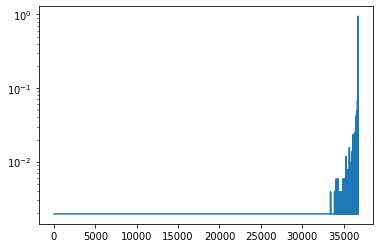

In [10]:
plt.plot(duprw[:-1])
plt.semilogy()

Most of the differences are equal, so a linear transformation from original values to integers seems likely. At high values, the differences increase, which would match the behaviour of only a few large values (not filling the entire integer space). Furthermore, the lower values likely have truncation, otherwise the differences would have some gaps there as well.

In [11]:
duprw[0]

0.001953125

In [12]:
np.median(duprw)

0.001953125

As the lowest and median values match, this is likely the step-size of the resulting integers, so by dividing by this size and adding / removing some offset, we should end up at nice integer steps with gaps for the highest values:

In [13]:
(uprw / 0.001953125 - 50.646545).astype("int")

array([    0,     1,     2, ..., 40941, 40954, 41031])

[]

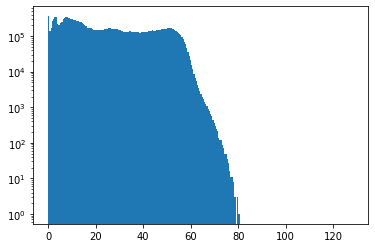

In [14]:
plt.hist(ds.prw.isel(time=299), bins=256, range=(50.646545*0.001953125, (2**16 + 50.646545)*0.001953125))
plt.semilogy()

The histogram is pretty smooth, so having a linear transform seems to be appropriate for this variable. Furthermore, we see that the upper half of the data space is relatively empty, so the theory for the larger gaps fits into this picture as well.

Let's now use the values transformed to integers as our testdata for compression tests:

In [15]:
prw_testdata = (ds.prw.isel(time=299).values / 0.001953125 - 50.646545).astype("uint16")
sbytes = bytes(prw_testdata)

In [16]:
import numcodecs

In [17]:
from aeccodec import AECCodec

## Test encoding speed, size and correctness for various codecs

In [18]:
def encode_chain(buffer, chain):
    for c in chain:
        buffer = c.encode(buffer)
    return buffer

def decode_chain(buffer, chain):
    for c in reversed(chain):
        buffer = c.decode(buffer)
    return buffer

In [40]:
chains = [
    ("zlib", [numcodecs.Zlib()]),
    ("AEC 16 8 2", [AECCodec(16, 8, 2)]),
    ("AEC 16 16 128", [AECCodec(16, 16, 128)]),
    ("delta,blosc/zstd", [numcodecs.Delta("uint16"),
                          numcodecs.Blosc("zstd", shuffle=numcodecs.Blosc.BITSHUFFLE)]),
    ("delta,blosc/lz4", [numcodecs.Delta("uint16"),
                          numcodecs.Blosc("lz4", shuffle=numcodecs.Blosc.BITSHUFFLE)]),
    ("blosc/zstd", [numcodecs.Blosc("zstd")]),
    ("blosc/lz4", [numcodecs.Blosc("lz4")]),
]

In [70]:
import timeit
import gc

def test(buffer, chain, rounds=10):
    compressed = encode_chain(buffer, chain)
    assert bytes(decode_chain(compressed, chain)) == bytes(buffer)
    ratio = len(bytes(compressed)) / len(bytes(buffer))
    encode_time = timeit.timeit(lambda: encode_chain(buffer, chain), number=rounds) / rounds
    gc.collect()
    decode_time = timeit.timeit(lambda: decode_chain(compressed, chain), number=rounds) / rounds
    gc.collect()
    return ratio, encode_time, decode_time

def _test_chains(buffer, chains):
    for name, chain in chains:
        try:
            ratio, encode_time, decode_time = test(buffer, chain)
            yield name, {"ratio": ratio, "encode_time": encode_time, "decode_time": decode_time}
        except AssertionError:
            yield name, None

def test_chains(buffer, chains):
    return dict(_test_chains(buffer, chains))

def print_test_results(test_tesults):
    for name, params in test_tesults.items():
        if params is not None:
            ratio = params["ratio"]
            encode_time = params["encode_time"]
            decode_time = params["decode_time"]
            print(f"{name:30s}: {ratio*100:7.1f}%  {encode_time:7.3}s {decode_time:7.3}s")
        else:
            print(f"{name:30s}: failed")

In [42]:
res = test_chains(sbytes, chains)
print_test_results(res)

zlib                          :    84.1%      1.6s   0.334s
AEC 16 8 2                    :    64.0%    0.424s   0.359s
AEC 16 16 128                 :    61.2%     0.33s   0.386s
delta,blosc/zstd              :    64.0%    0.241s    0.11s
delta,blosc/lz4               :    73.7%   0.0552s  0.0747s
blosc/zstd                    :    88.1%    0.314s  0.0261s
blosc/lz4                     :    99.5%   0.0425s 0.00779s


## repeated check on unscaled data

This is of course unfair against AEC, as AEC is made for encoding small integers and we are now confronting it with floats. Also delta-encoding for the other compression methods is not a sensible choice, as we've configures the delta-encoding for 16bit integers. Furthermore, be aware that the resulting compression ratios have float32 with 4 bytes as a reference value, so when comparing with the previous values, the following values should be doubled.

Nonetheless, it's interesting to have a look at how the codecs behave:

In [48]:
res_float = test_chains(ds.prw.isel(time=299).values, chains)
print_test_results(res_float)

zlib                          :    53.2%     2.16s   0.606s
AEC 16 8 2                    :   102.7%     0.64s    0.67s
AEC 16 16 128                 :   101.4%    0.511s    0.57s
delta,blosc/zstd              :    50.2%    0.918s   0.239s
delta,blosc/lz4               :    73.7%      0.2s   0.211s
blosc/zstd                    :    41.1%    0.492s  0.0413s
blosc/lz4                     :    51.7%   0.0508s  0.0183s


## some plots

In [49]:
import matplotlib.pyplot as plt
import numpy as np


def show_result(res, title):
    names, data = zip(*res.items())
    ratios, encode_times, decode_times = zip(*[(d["ratio"], d["encode_time"], d["decode_time"]) for d in data])

    x = np.arange(len(res))  # the label locations
    width = 0.35  # the width of the bars

    fig, (ax, ax2) = plt.subplots(2, figsize=(8,8), sharex=True)
    fig.set_facecolor('white')
    rects1 = ax.bar(x - width/2, encode_times, width, label='encode')
    rects2 = ax.bar(x + width/2, decode_times, width, label='decode')

    ax.set_ylabel('time / s')
    ax.set_title(title)
    ax.legend()


    rects3 = ax2.bar(x, ratios, width, label='ratio')
    ax2.set_ylabel('compression ratio')
    ax2.set_xticks(x, names, rotation='45')

    fig.tight_layout()

    plt.show()

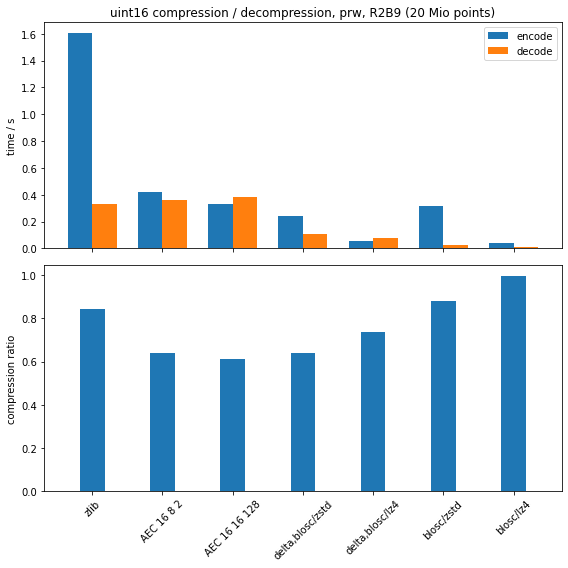

In [50]:
show_result(res, 'uint16 compression / decompression, prw, R2B9 (20 Mio points)')

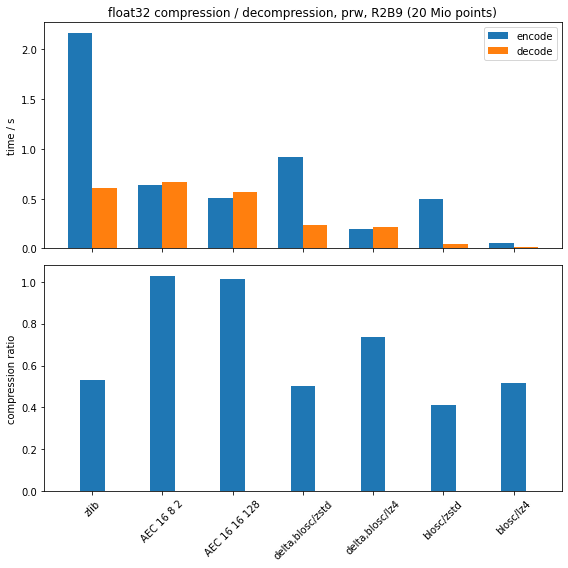

In [51]:
show_result(res_float, 'float32 compression / decompression, prw, R2B9 (20 Mio points)')

## redo for other variables
### tas

In [54]:
utas = np.unique(ds.tas.isel(time=299))

In [55]:
len(utas)

57343

In [61]:
1./np.median(np.diff(utas))

512.0

In [124]:
tasbytes = bytes(((ds.tas.isel(time=299).values - utas.min()) * 512).astype("uint16"))

In [137]:
tasres = test_chains(tasbytes, chains)
print_test_results(tasres)

zlib                          :    78.1%     1.47s   0.339s
AEC 16 8 2                    :    57.4%     0.44s   0.375s
AEC 16 16 128                 :    54.2%    0.343s   0.394s
delta,blosc/zstd              :    57.8%    0.285s   0.109s
delta,blosc/lz4               :    67.5%   0.0643s  0.0852s
blosc/zstd                    :    82.7%    0.553s  0.0306s
blosc/lz4                     :   100.0%   0.0145s  0.0101s


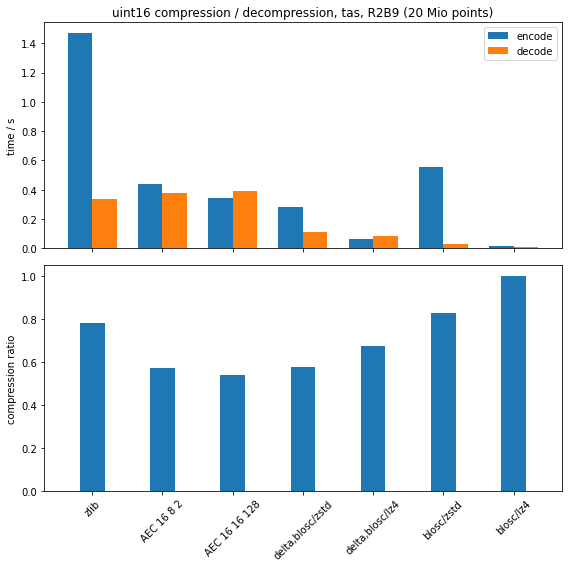

In [139]:
show_result(tasres, 'uint16 compression / decompression, tas, R2B9 (20 Mio points)')

### uas

In [141]:
uuas = np.unique(ds.uas.isel(time=299))

In [143]:
len(uuas)

43311

In [144]:
1./np.median(np.diff(utas))

512.0

In [145]:
uasbytes = bytes(((ds.uas.isel(time=299).values - uuas.min()) * 512).astype("uint16"))

In [146]:
uasres = test_chains(uasbytes, chains)
print_test_results(uasres)

zlib                          :    83.6%     1.61s   0.343s
AEC 16 8 2                    :    65.3%    0.422s    0.36s
AEC 16 16 128                 :    62.5%    0.332s    0.39s
delta,blosc/zstd              :    65.0%    0.285s   0.113s
delta,blosc/lz4               :    74.1%   0.0581s   0.078s
blosc/zstd                    :    87.4%    0.452s  0.0304s
blosc/lz4                     :   100.0%   0.0127s 0.00801s


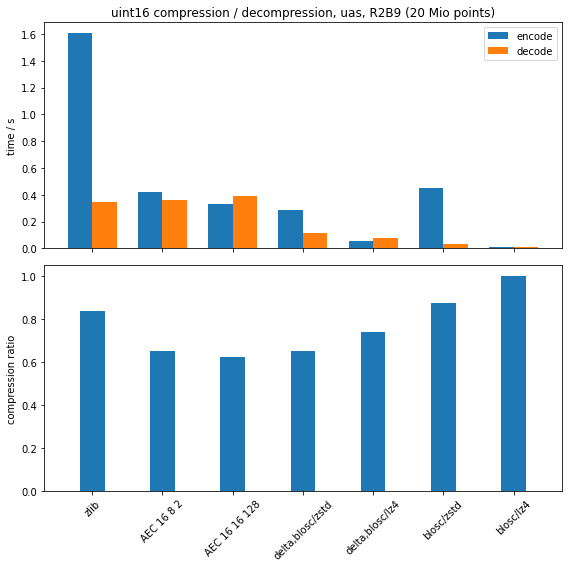

In [147]:
show_result(uasres, 'uint16 compression / decompression, uas, R2B9 (20 Mio points)')

## summary

The picture seems to repeat itself. Generally, AEC is able to compress way faster than zlib and gets best compression ratios (approx 60%). Using delta,blosc/zstd, one can get roughly the same compression ratio but at much faster decompression speeds. If data can't be converted to integers in a similar range, generic algorithms perform much better than AEC. If delta-encoding can be avoided, much faster compression / decompression speeds can be acchieved. `zlib` looses the race everywhere.